In [1]:
!pip install git+https://github.com/firekind/athena

  Cloning https://github.com/firekind/athena to /tmp/pip-req-build-oi3x9nzu
  Running command git clone -q https://github.com/firekind/athena /tmp/pip-req-build-oi3x9nzu
  Created wheel for athena: filename=athena-1.0.0-cp36-none-any.whl size=49671 sha256=cf6bcd5a5afa4d9cc1a1843bf46352055f940d57e472be757bbc221d720ce57f
  Stored in directory: /tmp/pip-ephem-wheel-cache-spx7y826/wheels/36/d3/7b/d9500a9af2498abc5d48d60c7db37c1456ee745049da352e0b
Successfully built athena


In [2]:
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, OneCycleLR, ReduceLROnPlateau

from athena import datasets, Experiment, Experiments, ClassificationSolver
from athena.visualizations import plot_experiments, plot_misclassified
from athena.utils.transforms import ToNumpy, ToTensor
from athena.models import ResNet18
from athena.tuning import lr_finder

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 128 if device == 'cuda' else 64
epochs = 50

cuda


In [4]:
net = ResNet18().to(device)

summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [5]:
import cv2

train_loader = (
    datasets.cifar10()
    .batch_size(batch_size)
    .train()
    .transform(A.Compose([
        A.Lambda(ToNumpy),
        A.PadIfNeeded(36, 36, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.RandomCrop(32, 32),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
        A.Lambda(ToTensor)
    ]))
    .build()
)

test_loader = (
    datasets.cifar10()
    .batch_size(batch_size)
    .test()
    .transform(A.Compose([
        A.Lambda(ToNumpy),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
        A.Lambda(ToTensor)
    ]))
    .build()
)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### LRFinder


Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.59E-02


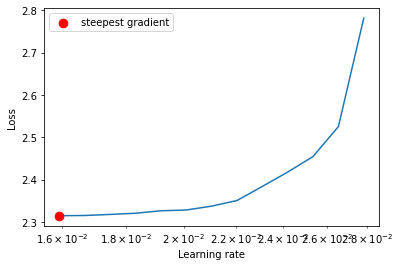

In [7]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = F.cross_entropy

lr_finder = lr_finder.LRFinder(net, optimizer, criterion, device=device)

# Starting range test
lr_finder.reset()
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=100, step_mode="exp")
res = lr_finder.plot()

In [9]:
# creating the experiment
exp = (
    Experiment.builder()
    .name("New Resnet 18 Model with Cutout")
    .log_directory("log_dir")
    # .add("ReduceLR - 1.59")
      .model(ResNet18())
      .solver(ClassificationSolver)
          .optimizer(optim.SGD, lr=1.59E-02, momentum=0.9)
          .scheduler(ReduceLROnPlateau, patience=5, factor=0.5)
          .epochs(epochs)
          .train_loader(train_loader)
          .test_loader(test_loader)
          .loss_fn(criterion)
          .device("cuda")
          .build()
      .build() 
)

# running experiment
exp.run()

=> Running experiment: New Resnet 18 Model with Cutout
Epoch: 1 / 50
782/782 [==============================] - 59s 75ms/step - train loss: 1.4123 - train accuracy: 49.2300
Test set: Average loss: 1.0565, Accuracy: 6345/10000 (63.45%)

Epoch: 2 / 50
782/782 [==============================] - 60s 76ms/step - train loss: 0.8644 - train accuracy: 69.4960
Test set: Average loss: 0.7943, Accuracy: 7257/10000 (72.57%)

Epoch: 3 / 50
782/782 [==============================] - 59s 76ms/step - train loss: 0.6800 - train accuracy: 76.2680
Test set: Average loss: 0.7007, Accuracy: 7654/10000 (76.54%)

Epoch: 4 / 50
782/782 [==============================] - 59s 76ms/step - train loss: 0.5605 - train accuracy: 80.4580
Test set: Average loss: 0.5800, Accuracy: 8054/10000 (80.54%)

Epoch: 5 / 50
782/782 [==============================] - 59s 75ms/step - train loss: 0.4891 - train accuracy: 83.1180
Test set: Average loss: 0.5393, Accuracy: 8197/10000 (81.97%)

Epoch: 6 / 50
782/782 [=================

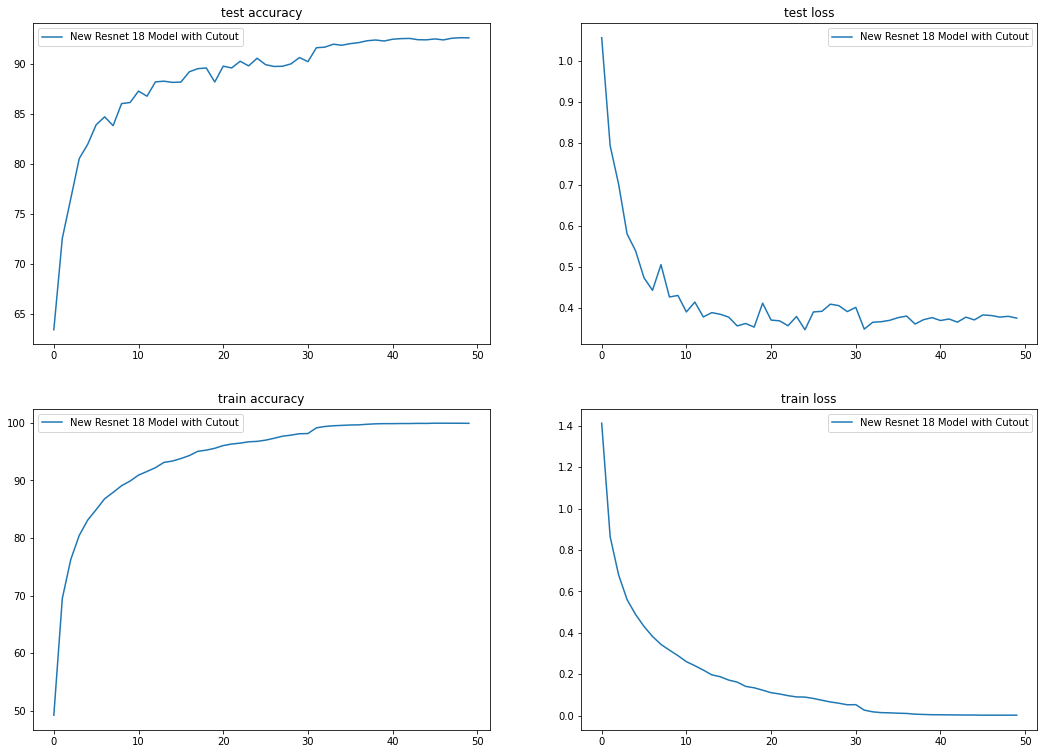

In [10]:
plot_experiments([exp])

In [12]:
from athena.visualizations import plot_experiments, gradcam_misclassified

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


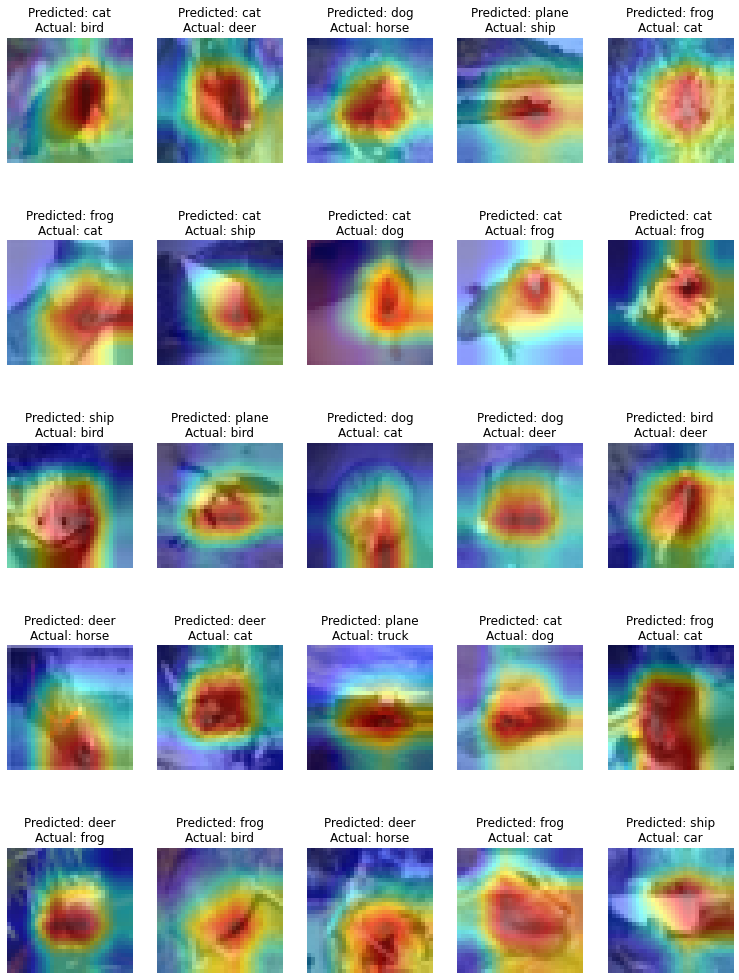

In [19]:
gradcam_misclassified(
    25,
    exp,
    exp.get_solver().model.layer4[1],
    test_loader,
    device,
    class_labels=('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
    mean=(0.485, 0.456, 0.406), 
    std=(0.229, 0.224, 0.225),
    alpha=0.8,
    figsize=(13, 18),
)